In [2]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import geocoder
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langchain_community.utilities import GoogleSerperAPIWrapper
import requests
from bs4 import BeautifulSoup
import re
import json
from dotenv import load_dotenv
load_dotenv()
import os
import requests
from geopy.geocoders import Nominatim
import streamlit as st
import re

from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.schema import Document

YOUTUBE_API_KEY = os.getenv('YOUTUBE_API_KEY')

In [3]:
llm_70b = ChatGroq(model="llama-3.1-70b-versatile", api_key=st.secrets["GROQ"]["GROQ_API_KEY"])
llm_8b = ChatGroq(model="llama-3.1-8b-instant", api_key=st.secrets["GROQ"]["GROQ_API_KEY"])

In [ ]:
file_path = "../data/doc_emergency/pdf/manuale_primo_soccorso.pdf"
loader = PyPDFLoader(file_path)
pages = loader.load()[40:]
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
# splits = text_splitter.split_documents(docs)
# vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())
# retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})
# Carica tutte le pagine come testo unico
full_text = "\n".join([doc.page_content for doc in pages])
full_text = full_text.replace("MANUALE PER GLI INCARICATI DI PRIMO SOCCORSO", "")
full_text = full_text.replace("LE POSIZIONI DI SICUREZZA", "")
full_text = full_text.replace("APPARATO VISIVO", "")
full_text = full_text.replace("APPARATO UDITIVO", "")
full_text = full_text.replace("SISTEMA NERVOSO - anatomia", "")
full_text = full_text.replace("IL SISTEMA NERVOSO\n", "")
full_text = full_text.replace("-\n", "")
full_text

'L ’APPARATO RESPIRATORIO\nANATOMIA\nL ’apparato respiratorio inizia nella bocca e nel naso, dove l’aria viene filtrata, riscaldata ed umidificata (fig. 1).\nNella bocca e poi nel faringe l’aria usa lo stesso passaggio del cibo.\nA valle del faringe il condotto si divide in due: posteriormente si trova l’esofago che\nconduce il cibo nello stomaco, anteriormente si trova prima la laringe e quindi la\ntrachea che veicola l’aria nei polmoni.\nNel punto in cui il faringe si divide, una valvola, detta epiglottide, impedisce al cibo,\nchiudendosi al suo passaggio, di entrare nelle vie aeree. \nLa trachea, corre lungo la parte inferiore del collo e la parte superiore del torace dove\nsi biforca in due rami divergenti il bronco destro e quello sinistro.\nCiascun bronco, entrato nel polmone, si suddivide in rami di calibro sempre più piccolo: i bronchioli maggiori e minori che terminano alla fine del loro percorso negli\nalveoli polmonari. \n25\n\nApparato Respiratorio\nFig. 1\nQuesti ultimi so

In [5]:
# Espressione regolare per identificare titoli in maiuscolo (che terminano con \n)
main_title_pattern = r'(?:\n|^)([A-Z\s\’\’]+(?:\n[A-Z\s\’\’]+)*)\n'
sub_section_pattern = r'(?:^|\n)([a-z]\))'  # Per riconoscere sottosezioni come "a)" o "b)"
degree_section_pattern = r'(?:^|\n)([IV]+\s+GRADO)'

# Mappa dei numeri di pagina
page_number_map = []
for page in pages:
    page_number_map.append({"text": page.page_content, "page_number": page.metadata["page"]})

# Trova tutti i titoli principali
matches = list(re.finditer(main_title_pattern, full_text))
documents = []
current_content = ""
current_title = None
current_page = None

for i in range(len(matches)):
    # Ottieni il titolo corrente
    title_start = matches[i].start()
    title_end = matches[i].end()
    title = full_text[title_start:title_end].strip()

    # Determina il contenuto fino al prossimo titolo principale o alla fine del testo
    if i + 1 < len(matches):
        content_start = title_end
        content_end = matches[i + 1].start()
        content = full_text[content_start:content_end].strip()
    else:
        content = full_text[title_end:].strip()

    # Trova il numero di pagina del titolo corrente
    if current_page is None:
        for page in page_number_map:
            if title in page["text"]:
                current_page = page["page_number"]
                break

    # Accorpa sottosezioni (es: "a)", "b)", "I GRADO", "II GRADO") al contenuto principale
    content_lines = content.split("\n")
    organized_content = []
    current_subsection = None

    for line in content_lines:
        # Riconosci sottosezioni come "a)", "b)"
        if re.match(sub_section_pattern, line):
            current_subsection = line
            organized_content.append(f"\n{line}")
        # Riconosci sezioni come "I GRADO", "II GRADO"
        elif re.match(degree_section_pattern, line):
            current_subsection = line
            organized_content.append(f"\n{line}")
        elif current_subsection:
            # Accorpa le righe successive alla sottosezione corrente
            organized_content[-1] += f" {line.strip()}"
        else:
            # Accorpa al contenuto principale
            organized_content.append(line.strip())

    content = "\n".join(organized_content)

    # Salva il documento precedente
    if current_title:
        documents.append({"title": current_title, "page_content": current_content, "page_nr": current_page})

    # Inizia un nuovo documento
    current_title = title
    current_content = content
    current_page = None  # Reset del numero di pagina

# Salva l'ultimo documento
if current_title:
    documents.append({"title": current_title, "page_content": current_content, "page_nr": current_page})

# Converti in oggetti Document compatibili con LangChain
documents = [
    Document(
        page_content=doc["page_content"],
        metadata={"title": doc["title"], "page_nr": doc["page_nr"]}
    )
    for doc in documents
]

In [6]:
# Step 1: Configura l'indice BM25 per i titoli
bm25_retriever = BM25Retriever.from_documents(
    documents
    #key_field="metadata.title"  # Usa i titoli nei metadata
)
bm25_retriever.k = 2
# Step 2: Configura FAISS per i contenuti
embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(documents, embedding=embedding)
similarity_retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

# Step 3: Configura un MultiRetriever
ensemble_retriever = EnsembleRetriever(retrievers=[
    bm25_retriever,
    similarity_retriever
], weights=[0.3, 0.7])

C:\Users\david\AppData\Local\Temp\ipykernel_10692\3602673820.py:8: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding = OpenAIEmbeddings()


In [7]:
# query = "Mi ha punto un'ape"
# response = ensemble_retriever.invoke(query)
# for ix, res in enumerate(response):
#     print(F"NUOVO INDICE: {ix}")
#     print(res.metadata['title'])
#     print(res)

In [8]:
class AgentState(TypedDict):
    query: str
    keywords: str
    search_results: str
    retry_count_youtube: int
    google_maps_url: str
    final_result: str
    user_location : str
    hospital_name : str
    rag_answer : str
    
    web_search_keywords : str
    retry_count_web_search : int
    web_answer : str



def log_state(node_name, state:AgentState):
    print(f"Node '{node_name}' State: {state}")

In [9]:
def answer_from_rag(state:AgentState):
    log_state("answer_from_rag", state)
    query = state['query']
    retrieved_docs = ensemble_retriever.invoke(query)
    retrieved_info = [doc.page_content for doc in retrieved_docs]
    prompt = f"""You are a highly experienced professional in emergency medicine with over 20 years of experience and certifications in Advanced Trauma Life Support (ATLS) and Prehospital Trauma Life Support (PHTLS). Your expertise lies in effectively managing life-threatening situations under pressure, with a calm demeanor and advanced skills that consistently save lives in critical moments.

    Your task is to provide immediate and accurate guidance for managing life-threatening emergencies, ensuring safety, critical intervention, and strict adherence to advanced emergency response protocols. 

    Your response must:
    - Include a clear, step-by-step guide for life-saving actions, tailored to the situation described in the query.
    - Reference the consulted materials by citing specific quotations or sections. Ensure that these citations are clear and directly support your guidance.
    - Emphasize the importance of contacting emergency services promptly and provide a brief explanation of when and why it is essential to do so.

    This is the user query: {query}
    These are the documents you should rely on for your response: {retrieved_info}
    
    If there are no useful information in the documents please return: 'NO INFO AVAILABLE'"""
    response = llm_70b.invoke([HumanMessage(content=prompt)])
    return {"rag_answer" : response.content.strip()}

In [10]:
def web_search(state: AgentState) -> str:
    """
    Searches the Internet to retrieve reliable and certified information related to a specific medical query.

    Args:
        query (str): A simplified Italian string, optimized for an effective Google search based on the user's query.

    Returns:
        str: A string containing useful and relevant information retrieved from certified websites related to the user's query. 
             If no pertinent information is found, it returns a message indicating the absence of results.
    """
    # Fase 1: Ricerca su Internet
    log_state("web_search", state)
    query = state['keywords']
    if not isinstance(query, str):
        return "Nessun contenuto pertinente trovato su Internet"
    compliant_links = ['my-personaltrainer', 'msdmanuals']
    serper = GoogleSerperAPIWrapper(api_key=os.environ["SERPER_API_KEY"])
    try:
        search_results = serper.results(query)['organic']
        # Filtra e seleziona un link per ciascun dominio compliant
        selected_links = []
        for domain in compliant_links:
            for result in search_results:
                if domain in result['link']:
                    selected_links.append(result['link'])
                    break  # Esci dal ciclo per passare al prossimo dominio

        general_content = []
        selected_links = [selected_links[0]]
        for url in selected_links:
            try:
                # Effettua una richiesta al sito
                response = requests.get(url)
                response.raise_for_status()  # Controlla se la richiesta è andata a buon fine
                
                # Analizza il contenuto della pagina con BeautifulSoup
                soup = BeautifulSoup(response.text, 'html.parser')
                
                # Estrai il contenuto principale della pagina (potresti dover adattare il selettore)
                page_content = soup.get_text(separator=' ', strip=True)
                
                general_content.append(page_content)

            except requests.exceptions.RequestException as e:
                print(f"NO Info")
        return {"web_answer" : general_content}
    except:
        return {"web_answer" : "NO Info"}
    
def extract_keywords_web_search(state:AgentState):
   log_state("extract_keywords_web_search", state)
   query = state['query']
   previous_keywords = state.get('web_search_keywords', '')
    # Costruisci il prompt
   prompt = f"""From the following user query: '{query}', extract the most relevant keywords to optimize the search for searching on some websites. Translate them into Italian.
    Return just a Json object with the key: 'keywords'
    Here are examples of user queries and the corresponding optimized output:""" + \
    """
    1. Query: "I am feeling anxious, I think I am having a panic attack. What should I do?" 
       Output : {"keywords": "attacco di panico, primo soccorso"}
    2. Query: "Cosa devo fare se mi punge un'ape?"
       Output : {"keywords": "Puntura ape, primo soccorso"}
    3. Query: "Come medicare un taglio profondo fatto con un coltello?"
       Output : {"keywords": "Taglio profondo coltello, primo soccorso"}
    4. Query: "Come trattare una scottatura con acqua bollente?"
       Output : {"keywords": "Scottatura acqua bollente, primo soccorso"}
    5. Query: "Cosa fare in caso di reazione allergica improvvisa?"
       Output : {"keywords": "Reazione allergica, primo soccorso"}"""

   if previous_keywords:
        prompt += f" Previous search with keywords '{previous_keywords}' returned no results. Try a different search query."
        
   # Chiamata al modello LLM
   response = llm_70b.invoke([HumanMessage(content=prompt)])
   return {"web_search_keywords": json.loads(response.content)["keywords"], "retry_count_web_search" : state["retry_count_web_search"]+1}



# Funzione per controllare se continuare
def should_continue_web_search(state:AgentState):
    web_search_results = state.get('web_answer', '')
    log_state("should_continue_web_search", state)
    print(state['retry_count_web_search'])
    retry_count_web_search = state.get('retry_count_web_search', 0)
    if (not web_search_results or web_search_results == "NO Info") and retry_count_web_search <2:
        # Incrementa il contatore dei retry
        return "retry"
    return "end"


# Funzione per controllare se continuare
def should_web_search(state:AgentState):
    rag_answer = state.get('rag_answer', '')
    if not rag_answer or "no info available" in rag_answer.lower():
        return "web_search"
    return "end"

In [11]:
def extract_keywords_with_llm(state:AgentState):
   log_state("extract_keywords_with_llm", state)
   query = state['query']
   previous_keywords = state.get('keywords', '')
    # Costruisci il prompt
   prompt = f"""From the following user query: '{query}', extract the most relevant keywords to optimize the search for a video on YouTube. Translate them into English.
    Return just a Json object with the key: 'keywords'
    Here are examples of user queries and the corresponding optimized output:""" + \
   """
    1. Query: "I am feeling anxious, I think I am having a panic attack. What should I do?" 
       Output : {"keywords": "panic attack, first aid"}
    2. Query: "Cosa devo fare se mi punge un'ape?"
       Output : {"keywords": "bee sting treatment, first aid"}
    3. Query: "Come medicare un taglio profondo fatto con un coltello?"
       Output : {"keywords": "knife deep cut treatment, first aid"}
    4. Query: "Come trattare una scottatura con acqua bollente?"
       Output : {"keywords": "boiling water burn, first aid"}
    5. Query: "Cosa fare in caso di reazione allergica improvvisa?"
       Output : {"keywords": "allergic reaction help, first aid"} """

   if previous_keywords:
        prompt += f" Previous search with keywords '{previous_keywords}' returned no results. Try a different search query."
   
    # Chiamata al modello LLM
   response = llm_70b.invoke([HumanMessage(content=prompt)])
   print(response.content)
   return {"keywords": json.loads(response.content)["keywords"], "retry_count_youtube" : state["retry_count_youtube"]+1}



# Funzione per controllare se continuare
def should_continue_youtube(state:AgentState):
    search_results = state.get('search_results', '')
    retry_count_youtube = state.get('retry_count_youtube', 0)
    if (not search_results or "No videos found" in search_results) and retry_count_youtube <2:
        return "retry"
    return "end"

In [12]:
def search_youtube_videos(state:AgentState) -> str:
    """
    Cerca video su YouTube da una lista certificata di canali affidabili.

    Args:
        query (str): Una versione semplificata e in inglese, adatta per una ricerca su youtube, della query di ricerca fornita dall'utente.

    Returns:
        str: Un di link utile rispetto alla query, o un messaggio che indica che non sono stati trovati video.
    """
    log_state("search_youtube_videos", state)
    keywords = state['keywords']
    if not isinstance(keywords, str):
        return "Nessun video pertinente trovato per la query specificata nei canali consentiti."
    YOUTUBE_SEARCH_URL = "https://www.googleapis.com/youtube/v3/search"
    allowed_channels=['UCwywRelPfy7U8jAI312J_Xw', #First Aid,
                      'UCQK834Q3xqlo85LJqrEd7fw' #ChatterDocs
                      ]  #'UCTVZkcCKSqFD0TTJ8BjYLDQ' Croce Rossa, 
    max_results = 1
    try:
        for channel_id in allowed_channels:
            params = {
                "part": "snippet",
                "q": keywords,
                "channelId": channel_id,
                "maxResults": max_results,
                "type": "video",
                "key": YOUTUBE_API_KEY,
            }

            response = requests.get(YOUTUBE_SEARCH_URL, params=params)
            data = response.json()

            # Controlla se ci sono risultati
            if "items" in data and len(data["items"]) > 0:
                # Restituisci il link al primo video trovato
                video_id = data["items"][0]["id"]["videoId"]
                return {"search_results": f"https://www.youtube.com/watch?v={video_id}"}
    except requests.exceptions.RequestException as e:
        return {"search_results": f"Error during YouTube search: {str(e)}"}
    return {"search_results": "No relevant videos found for the given query on the allowed channels."}

In [13]:
def find_nearest_hospital(state:AgentState):
    user_location = state.get("user_location")
    if not user_location:
        return {"hospital_name": "No location available"}
    
    # Costruisci il prompt per l'LLM
    prompt = f"""Based on the user location (latitude: {user_location[0]}, longitude: {user_location[1]}), provide the name of the nearest hospital.
    Return just the Hospital Name"""
    response = llm_70b.invoke([HumanMessage(content=prompt)])
    
    # Estrarre il nome dell'ospedale dalla risposta
    hospital_name = response.content.strip()
    return {"hospital_name": hospital_name}

def get_google_maps_url(state:AgentState) -> str:
    """
    Returns a Google Maps URL for the hospital name.
    
    Args:
        hospital_name (str): A string indicating the name of the hospital to search for.
        
    Returns:
        str: A Google Maps URL for the location, or a message indicating the location was not found.
    """
    hospital_name = state.get("hospital_name")
    if not hospital_name or hospital_name == "No location available":
        return {"google_maps_url": "No valid hospital information available"}
    geolocator = Nominatim(user_agent="MyExampleLLAMAFirstAid")
    location = geolocator.geocode(hospital_name)
    if location:
        return {"google_maps_url": f"https://www.google.com/maps?q={location.latitude},{location.longitude}"}
    else:
        return {"google_maps_url": "No valid hospital information available"}

In [14]:
def start_emergency_bot(state:AgentState):
    # Nodo di coordinamento iniziale, ritorna lo stato invariato
    return state

In [15]:
def combine_results(state:AgentState):
    video_result = state.get("search_results", "No video found.")
    google_maps_url = state.get("google_maps_url", "No hospital information found.")
    if state.get("web_answer", ""):
        doc_answer = state["web_answer"]
    else:
        doc_answer = state.get("rag_answer", "")
    
    # Risultato combinato
    combined_message = f"{doc_answer} \n Analizza questo video: {video_result}\nGoogle Maps Link: {google_maps_url}"
    return {"final_result": combined_message}

In [ ]:
# Creazione del grafo
graph = StateGraph(AgentState)

# Nodo iniziale per avviare i flussi paralleli
graph.add_node("start_emergency_bot", start_emergency_bot)

# Setta "start_emergency_bot" come entry point
graph.set_entry_point("start_emergency_bot")

# Aggiunta dei nodi
graph.add_node("extract_keywords_with_llm", extract_keywords_with_llm)
graph.add_node("search_youtube_videos", search_youtube_videos)
graph.add_node("answer_from_rag", answer_from_rag)
graph.add_node("web_search", web_search)


graph.add_edge("extract_keywords_with_llm", "search_youtube_videos")
graph.add_conditional_edges(
    "search_youtube_videos",
    should_continue_youtube,
    {
        "retry": "extract_keywords_with_llm",
        "end": "combine_results",
    }
)

# Secondo agente (Location)
graph.add_node("find_nearest_hospital", find_nearest_hospital)
graph.add_node("get_google_maps_url", get_google_maps_url)
graph.add_edge("find_nearest_hospital", "get_google_maps_url")



# Terzo agente (Combinazione risultati)
graph.add_node("combine_results", combine_results)

# Integrazione flussi paralleli
# graph.add_edge("search_youtube_videos", "combine_results")
graph.add_edge("get_google_maps_url", "combine_results")
graph.add_conditional_edges(
    "answer_from_rag",
    should_web_search,
    {
        "web_search": "extract_keywords_web_search",
        "end": "combine_results",
    }
)

graph.add_node("extract_keywords_web_search", extract_keywords_web_search)
graph.add_edge("extract_keywords_web_search", "web_search")
graph.add_conditional_edges(
    "web_search",
    should_continue_web_search,
    {
        "retry": "extract_keywords_web_search",
        "end": "combine_results",
    }
)
# Collegamenti ai flussi paralleli
graph.add_edge("start_emergency_bot", "extract_keywords_with_llm")
graph.add_edge("start_emergency_bot", "find_nearest_hospital")
graph.add_edge("start_emergency_bot", "answer_from_rag")

graph.set_finish_point("combine_results")

# Compilazione del grafo
app = graph.compile()

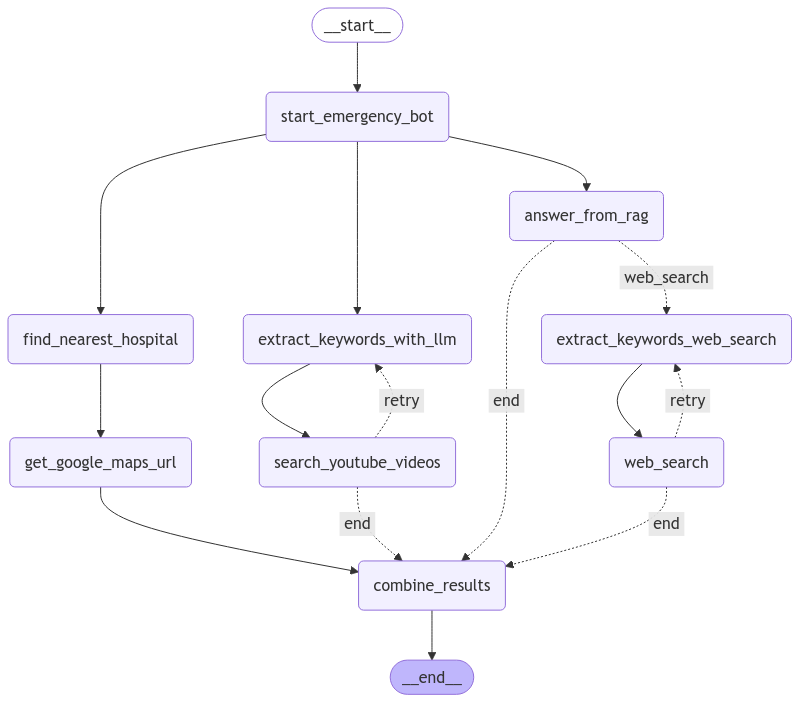

In [18]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [22]:
# Ottieni la posizione dell'utente tramite IP
location = geocoder.ip('me')
user_location = location.latlng if location.latlng else None

input_query = {
    "query": "Mi ha punto un'ape",
    "retry_count_youtube": 0,  # Inizializzazione del conteggio
    "retry_count_web_search": 0, 
    "user_location" : user_location
}
for output in app.stream(input_query):
    print("Output del nodo:", output)
    if 'combine_results' in output:
        final_output = output

Output del nodo: {'start_emergency_bot': {'query': "Mi ha punto un'ape", 'retry_count_youtube': 0, 'user_location': [41.8919, 12.5113], 'retry_count_web_search': 0}}
Node 'extract_keywords_with_llm' State: {'query': "Mi ha punto un'ape", 'retry_count_youtube': 0, 'user_location': [41.8919, 12.5113], 'retry_count_web_search': 0}
Node 'answer_from_rag' State: {'query': "Mi ha punto un'ape", 'retry_count_youtube': 0, 'user_location': [41.8919, 12.5113], 'retry_count_web_search': 0}
{"keywords": "bee sting treatment, first aid"}
Output del nodo: {'extract_keywords_with_llm': {'keywords': 'bee sting treatment, first aid', 'retry_count_youtube': 1}}
Output del nodo: {'find_nearest_hospital': {'hospital_name': 'Based on the location (latitude: 41.8919, longitude: 12.5113), the nearest hospital is:\n\nOspedale Santo Spirito'}}
Output del nodo: {'answer_from_rag': {'rag_answer': 'Sulla base delle informazioni fornite, sembra che tu abbia subito una puntura di ape. È importante agire con prudenz

In [26]:
def get_user_location():
    """
    Ottieni la posizione dell'utente tramite IP.
    
    Returns:
        tuple: Latitudine e longitudine dell'utente o None se non disponibile.
    """
    location = geocoder.ip('me')
    return location.latlng if location.latlng else (None, None)

In [ ]:
def get_google_maps_url():
    """
    Trova l'ospedale più vicino utilizzando la Google Places API.

    Args:
        lat (float): Latitudine dell'utente.
        lng (float): Longitudine dell'utente.
        api_key (str): Google Maps API Key.

    Returns:
        dict: Informazioni sull'ospedale più vicino o un messaggio di errore.
    """
    # URL dell'API di Google Places
    places_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    lat, lng = get_user_location()
    user_location_url = f"https://www.google.com/maps?q={lat},{lng}"
    google_maps_api_key = st.secrets["GOOGLE_MAPS"]["GOOGLE_MAPS_API_KEY"]
    # Parametri della richiesta
    params = {
        "location": f"{lat},{lng}",  # Latitudine e longitudine
        "radius": 10000,             # Raggio di ricerca in metri (es. 7km)
        "type": "hospital",         # Tipo di luogo da cercare
        "key": google_maps_api_key,             # Google API Key
    }

    try:
        # Invia la richiesta
        response = requests.get(places_url, params=params)
        data = response.json()
        print(data)

        # Controlla se ci sono risultati
        if "results" in data and len(data["results"]) > 0:
            nearest_hospital = data["results"][0]  # Il primo risultato è il più vicino
            print(nearest_hospital)
            hospital_name = nearest_hospital["name"]
            address = nearest_hospital.get("vicinity")
            location = nearest_hospital["geometry"]["location"]
            print(address)
            return {
                "hospital_name": hospital_name,
                "google_maps_url": f"https://www.google.com/maps?q={location['lat']},{location['lng']}",
            }
        else:
            return {"google_maps_url": "No hospitals found nearby."}
    except requests.exceptions.RequestException as e:
        return {"google_maps_url": f"Request failed: {str(e)}"}

In [47]:
get_google_maps_url()

{'html_attributions': [], 'next_page_token': 'AdDdOWq9C36i9-J0qTT5XdS5Zm9cXtPQlyFNWT5ZJ8sIfY6F0ulSKyUMQT_PQO55eHGfKhie4xyjKTBU5TMXT9kR_CUfBnLOENx63_RxDWKn9Pnz098XVNMBHQtN5RBRf8O75cQhmmleYuoIFUJGx-Cwm0H7rvc8Schvy3tjGUsgoDNqPIJsAToWoOQYsS23O7m6RhYLPr9euzmSB3ht78oqM2avpHlsu6Ogt_a69fL3qWentAwOEWtbn2ieKatjZLylGq5NtYGBOxuruD9X-9ayMIXo5A_rUFtHQo3veFkZ1IisesLhE8vFTkTHALS9Iwv_uCGpxXktfGgNvQd8XKJEo3OUUaGzQ_PXVq2gz6BWvnvUtZ2Liy-vvrgroR5Df3f4lEgsapkwrfDHyWVsArgpkoYWzc_1WBUTmgemE41QCRmlQo-z7nYUAbErkw', 'results': [{'business_status': 'OPERATIONAL', 'geometry': {'location': {'lat': 41.8933848, 'lng': 12.5554896}, 'viewport': {'northeast': {'lat': 41.8946310802915, 'lng': 12.5567281802915}, 'southwest': {'lat': 41.89193311970851, 'lng': 12.5540302197085}}}, 'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/hospital-71.png', 'icon_background_color': '#F88181', 'icon_mask_base_uri': 'https://maps.gstatic.com/mapfiles/place_api/icons/v2/hospital-H_pinlet', 'name': 'Fabia Mater', 'open

{'hospital_name': 'Fabia Mater',
 'google_maps_url': 'https://www.google.com/maps?q=41.8933848,12.5554896'}